# Explore the dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

df = pd.read_csv('us_df_final_2015_2023.csv', index_col = 0)
df.set_index('date', inplace=True)
# df.info()  # Falls du Informationen über den DataFrame anzeigen möchtest
#df

# Step 1: Check for stationarity of time series
## Method #1: time series plot

<Axes: xlabel='date'>

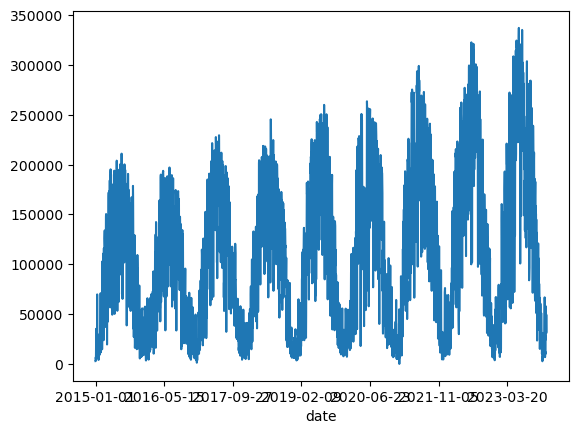

In [2]:
df['Act_in_MW'].plot()

In [3]:
# Konvertiere die "date"-Spalte in ein DateTime-Objekt
#df['date'] = pd.to_datetime(df['date'])

# Sortiere die Daten nach Datum, falls sie noch nicht sortiert sind
#df = df.sort_values(by='date')

# Trainingsset (erste 9 Jahre)
#train_end_date = df['date'].min() + pd.DateOffset(years=8)
#df_train = df[df['date'] < train_end_date].copy()

# Testset (verbleibende Daten)
#df_test = df[df['date'] >= train_end_date].copy()

# Überprüfe die Struktur der resultierenden DataFrames
#print(df_train.info())
#print(df_test.info())

## Decomposition

<Figure size 640x480 with 0 Axes>

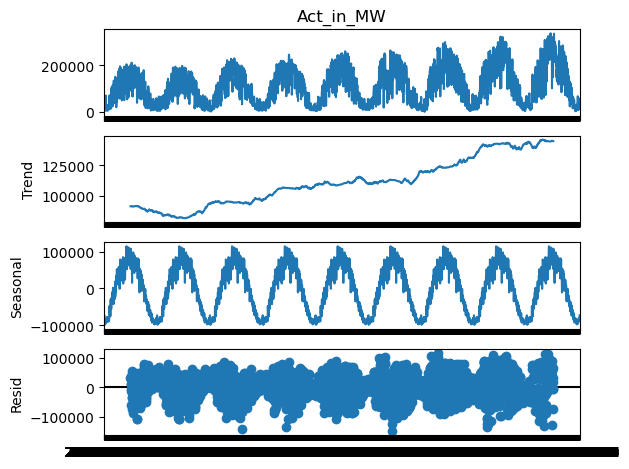

In [4]:
# Assuming 'Act_in_MW' is the column you want to decompose
# Perform seasonal decomposition
decomposition = seasonal_decompose(df['Act_in_MW'], period=365)  

# Plot the decomposed components
fig = plt.figure()  
fig = decomposition.plot()  
plt.show()

In [5]:
trend = decomposition.trend
seasonal = decomposition.seasonal 
residual = decomposition.resid 

# Method #2: ADF Stationarity test 


In [6]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries):
    # Determing rolling statistics
    rolmean = timeseries.rolling(window=52).mean()
    rolstd = timeseries.rolling(window=52).std()

    # Plot rolling statistics
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()

    # Perform Dickey-Fuller test
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

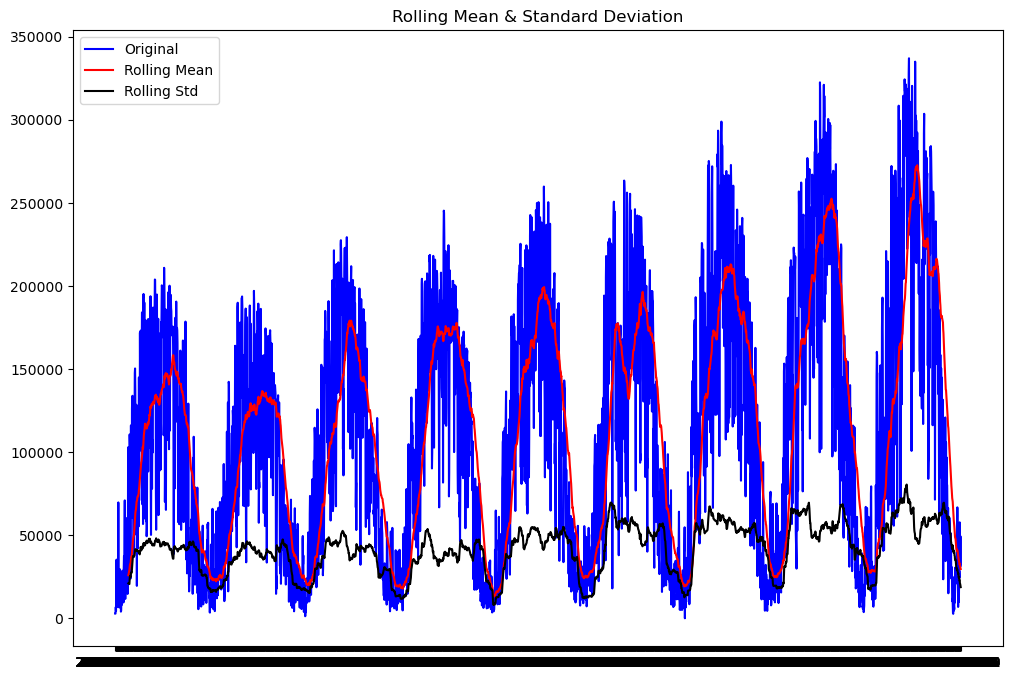

Results of Dickey-Fuller Test:
Test Statistic                   -3.457697
p-value                           0.009142
#Lags Used                       18.000000
Number of Observations Used    3268.000000
Critical Value (1%)              -3.432353
Critical Value (5%)              -2.862425
Critical Value (10%)             -2.567241
dtype: float64


In [7]:
# Beispielaufruf mit der Spalte 'Act_in_MW'
test_stationarity(df['Act_in_MW'])

# Transform to stationary: differencing

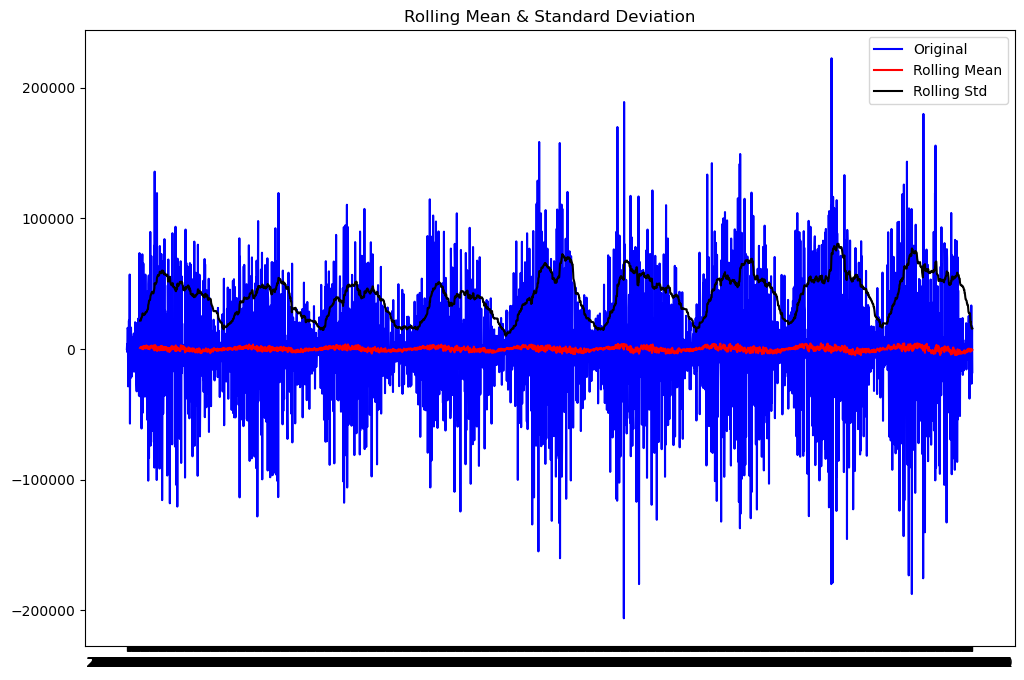

Results of Dickey-Fuller Test:
Test Statistic                -1.732763e+01
p-value                        5.434025e-30
#Lags Used                     2.200000e+01
Number of Observations Used    3.263000e+03
Critical Value (1%)           -3.432356e+00
Critical Value (5%)           -2.862426e+00
Critical Value (10%)          -2.567242e+00
dtype: float64


In [8]:
df['first_difference'] = df['Act_in_MW'] - df['Act_in_MW'].shift(1)
test_stationarity(df['first_difference'].dropna(inplace = False))

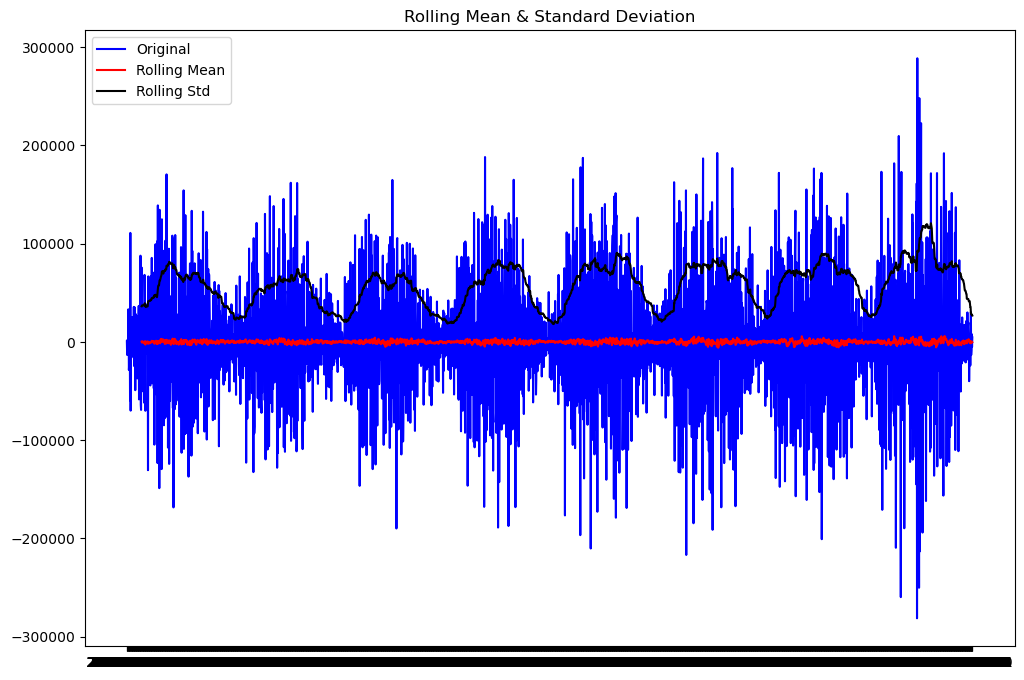

Results of Dickey-Fuller Test:
Test Statistic                -1.652604e+01
p-value                        2.043683e-29
#Lags Used                     2.800000e+01
Number of Observations Used    2.892000e+03
Critical Value (1%)           -3.432613e+00
Critical Value (5%)           -2.862540e+00
Critical Value (10%)          -2.567302e+00
dtype: float64


In [9]:
# Beispiel: Berechnung der ersten Differenz
df['first_difference'] = df['Act_in_MW'].diff()

# Beispiel: Berechnung der saisonalen Differenz
df['seasonal_first_difference'] = df['first_difference'] - df['first_difference'].shift(365)

# Test auf Stationarität
test_stationarity(df['seasonal_first_difference'].dropna(inplace=False))

# Method #3: ACF plot and PACF plot

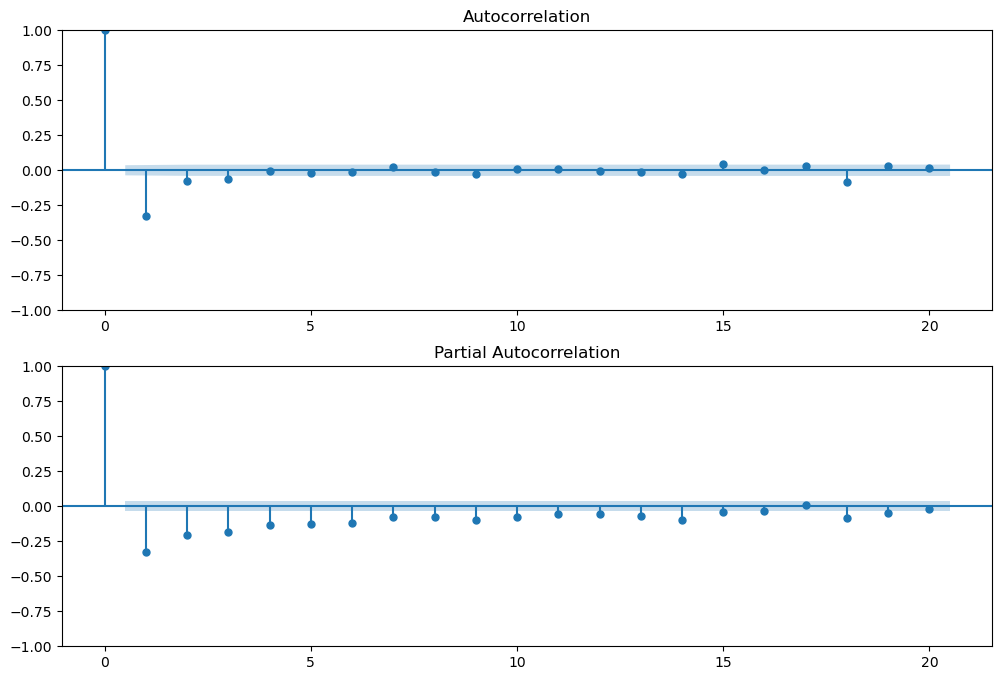

In [10]:
import statsmodels.api as sm
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df.seasonal_first_difference.iloc[366:], lags=20, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df.seasonal_first_difference.iloc[366:], lags=20, ax=ax2)

# Step 2: Determine ARIMA models parameters p,d, q and seasonal_pdq

In [51]:
#df
# Convert index to DatetimeIndex
df.index = pd.to_datetime(df.index)

# Downsample to weekly frequency by summing the daily values
df_weekly = df.resample('W').sum()
#df_weekly

#df = pd.read_csv('us_df_final_2015_2023.csv',index_col='Unnamed: 0',parse_dates=['date'])
#df.loc[:,'Month'] = df.loc[:,'date'].dt.month
#df.loc[:,'Year'] = df.loc[:,'date'].dt.year
#df.loc[:,'Calendar_Week'] = df.loc[:,'date'].dt.strftime('%U')
#und Year, Month, Calendar_Week mit oneHotEncoding aufdröseln

In [12]:
import itertools
import statsmodels.api as sm
import warnings

# Ignore specific type of warning
warnings.filterwarnings("ignore", category=Warning)

# Parameterkombinationen für die Grid-Suche
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 52) for x in pdq]  # Tägliche saisonale Komponente

best_aic = float("inf")
best_pdq = None
best_seasonal_pdq = None
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(df_weekly['Act_in_MW'], order=param, seasonal_order=param_seasonal, enforce_stationarity=False, enforce_invertibility=False)
            results = mod.fit()
            if results.aic < best_aic:
                best_aic = results.aic
                best_pdq = param
                best_seasonal_pdq = param_seasonal
        except:
            continue

print('Best AIC:', best_aic)
print('Best Parameters:', best_pdq, best_seasonal_pdq)

Best AIC: 9973.870017953193
Best Parameters: (1, 1, 1) (0, 1, 1, 52)


# Step 3: Fit the ARIMA model

In [47]:
mod = sm.tsa.statespace.SARIMAX(df_weekly.Act_in_MW, order=(0,1,1), seasonal_order=(0,1,1,52))
results = mod.fit()
print(results.summary())

                                     SARIMAX Results                                      
Dep. Variable:                          Act_in_MW   No. Observations:                  470
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 52)   Log Likelihood               -5722.311
Date:                            Wed, 13 Mar 2024   AIC                          11450.621
Time:                                    10:25:32   BIC                          11462.720
Sample:                                01-04-2015   HQIC                         11455.405
                                     - 12-31-2023                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.6723      0.051    -13.115      0.000      -0.773      -0.572
ma.S.L52      -0.7093      0.066   

date
2015-01-04              NaN
2015-01-11              NaN
2015-01-18              NaN
2015-01-25              NaN
2015-02-01              NaN
                  ...      
2023-12-03    164706.904264
2023-12-10    135948.111140
2023-12-17    140692.837148
2023-12-24    196606.366497
2023-12-31    200289.588615
Freq: W-SUN, Name: forecast, Length: 470, dtype: float64

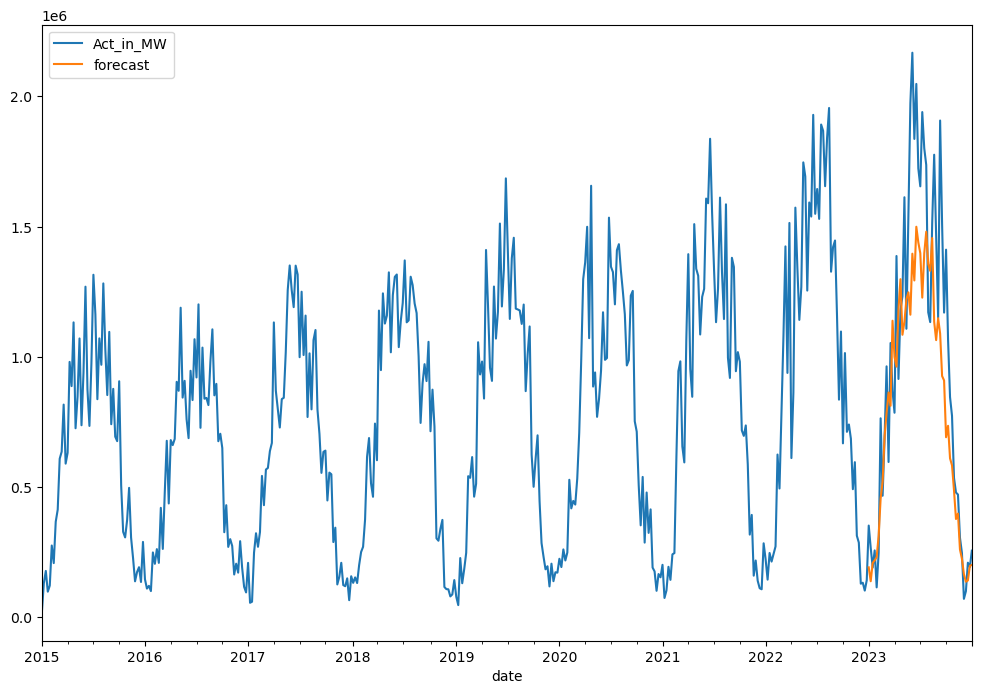

In [65]:
df_weekly['forecast'] = results.predict(start = '2023-01-01', end= '2023-12-31', dynamic= True)  
df_weekly[['Act_in_MW', 'forecast']].plot(figsize=(12, 8))
df_weekly['forecast']

# Step 4: Make time series predictions

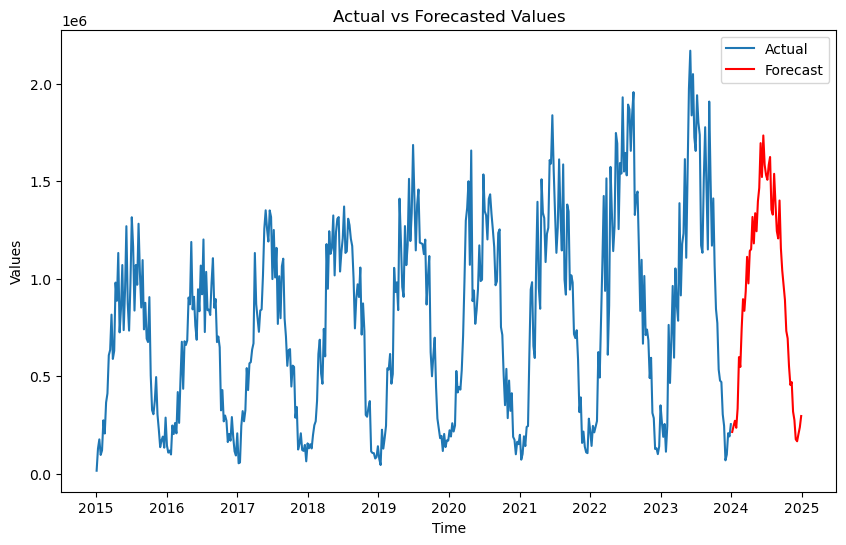

In [23]:
# Prediction
# Forecast future values (e.g., for next 52 steps)
forecast_steps = 52
forecast = results.get_forecast(steps=forecast_steps)
# Extract forecasted values
forecast_values = forecast.predicted_mean

# Visualization
plt.figure(figsize=(10, 6))
plt.plot(df_weekly.index, df_weekly.Act_in_MW, label='Actual')
plt.plot(forecast_values.index, forecast_values, label='Forecast', color='red')
plt.title('Actual vs Forecasted Values')
plt.xlabel('Time')
plt.ylabel('Values')
plt.legend()
plt.show()

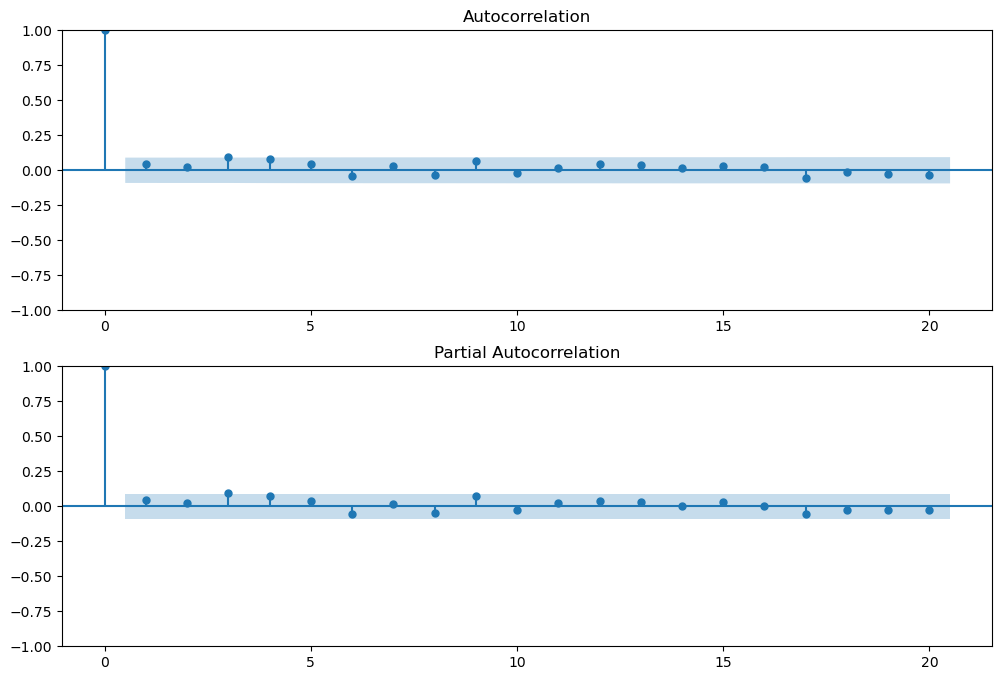

In [38]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.show()
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = plot_acf(residuals, lags=20, ax=ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(residuals, lags=20, ax=ax2)

# Step 5: Evaluate model predictions

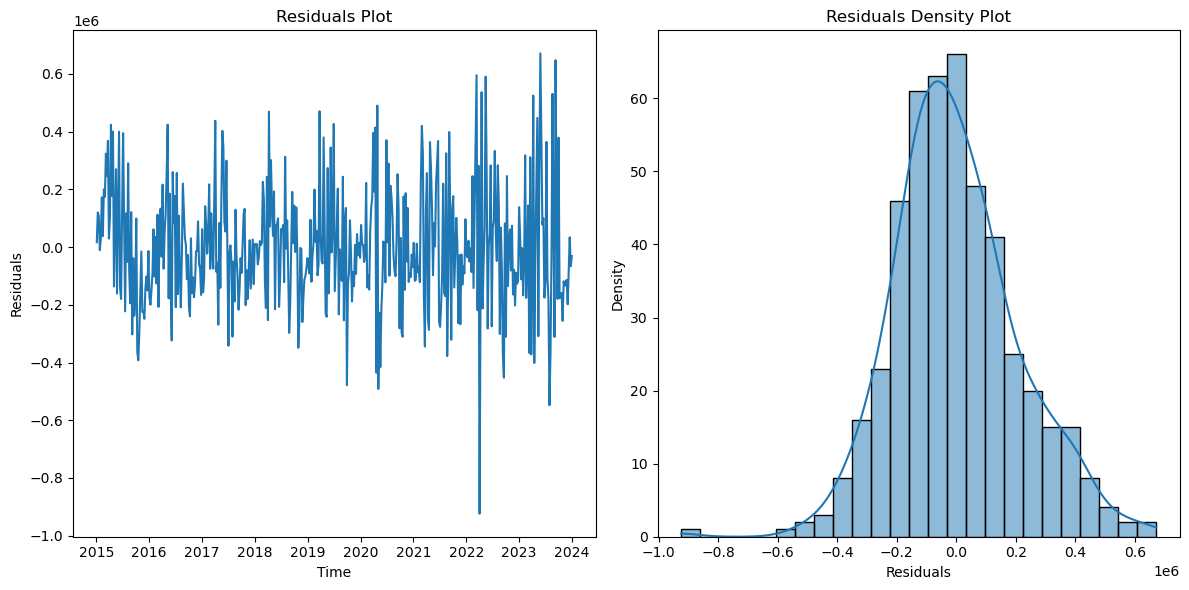

In [32]:
import seaborn as sns
# Calculate residuals
residuals = results.resid

# Plot residuals
plt.figure(figsize=(12, 6))

# Plot residuals
plt.subplot(1, 2, 1)
plt.plot(residuals)
plt.title('Residuals Plot')
plt.xlabel('Time')
plt.ylabel('Residuals')

# Plot density
plt.subplot(1, 2, 2)
sns.histplot(residuals, kde=True)
plt.title('Residuals Density Plot')
plt.xlabel('Residuals')
plt.ylabel('Density')

plt.tight_layout()
plt.show()

Residual Mean Absolute Error: 161266.60114154365
Residual Mean Squared Error: 43326885095.59849
Residual Root Mean Squared Error: 208151.11120433273


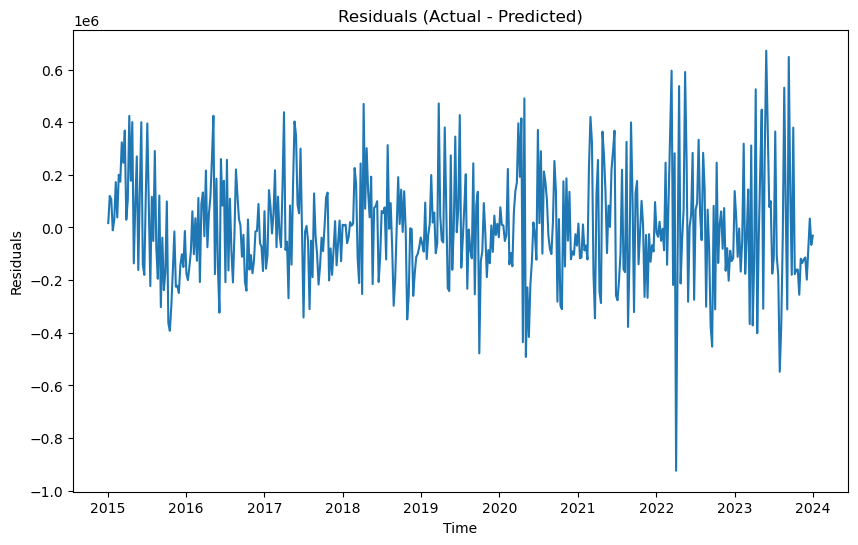

In [36]:
# Calculate residuals
residuals = actual_values - predicted_values

# Calculate error metrics for residuals
residual_mae = np.mean(np.abs(residuals))
residual_mse = np.mean(residuals**2)
residual_rmse = np.sqrt(residual_mse)

# Print error metrics for residuals
print("Residual Mean Absolute Error:", residual_mae)
print("Residual Mean Squared Error:", residual_mse)
print("Residual Root Mean Squared Error:", residual_rmse)

# Plot residuals
plt.figure(figsize=(10, 6))
plt.plot(residuals)
plt.title('Residuals (Actual - Predicted)')
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.show()


# Other suggestions